## Homework 5 - The eternal significance of publications and citations!
#### Group 18: Yousef Kanj (2113258), Simone Zagaria (2145389), Matteo Pazzini (1868953), Sai Swaroop Chittoor (1916247) 
_____

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import ijson
import time
from prettytable import PrettyTable 
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
start = time.process_time()

### Exploratory data analysis 

Since the JSON file provided had a large number of fields, what we did was to read it line by line (using the ijson library), extracting only the columns on interest and appending them to a Pandas Dataframe. <br>
We then sorted by the number of citation to obtain the top 10k papers.



papers = []

with open('dblp.v12.json', "rb") as file:
    for i, element in enumerate(ijson.items(file, "item")):

        # Extracting the most valuable data
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']
        paper['authors'] = element.get('authors',np.nan)
        paper['year'] = element.get('year', np.nan)
        paper['n_citation'] = element.get('n_citation', 0)
        paper['doc_type'] = element.get('doc_type', np.nan)
        paper['references'] = element.get('references', np.nan)
        paper['doi'] = f"https://doi.org/{element['doi']}" if 'doi' in element else np.nan
        papers.append(paper)
        if i%100000 ==0:
            print(f"{i}:{round((time.process_time() - start),2)}s ",end="") 
csvread = pd.DataFrame(papers)
first_10k_rows = csvread.sort_values(by="n_citation",ascending=False).iloc[:10000]
first_10k_rows.to_csv("first_10k_rows.csv")
first_10k_rows.head(10)


In [2]:
first_10k_rows = pd.read_csv("first_10k_rows.csv")

def authors_to_dict(input_string): # This function converts the authors column to a clean dictionary with ID as key and name as value
    pattern = r"'name':\s*'([^']+)'.*?'id':\s*(\d+)(?:,.*?|})"
    matches = re.findall(pattern, input_string)

    result_dict = {int(id_): name for name, id_ in matches}

    return result_dict
first_10k_rows["references"] = first_10k_rows["references"].apply(lambda x: list(map(int, x.strip("[]").split(", "))) if type(x) != float else x)
first_10k_rows["authors"] = first_10k_rows["authors"].apply(authors_to_dict)

first_10k_rows.head()

Unnamed: 0          id                                              title  \
0     4696136  2041404167           The Mathematical Theory of Communication   
1     4630907  1639032689  Genetic algorithms in search, optimization, an...   
2     4092588  2912565176                                         Fuzzy sets   
3     2937610  2151103935  Distinctive Image Features from Scale-Invarian...   
4     4088311  2911964244                                     Random Forests   

                             authors  year  n_citation doc_type  \
0      {2247248564: 'C. E. Shannon'}  1949       48327     Book   
1  {2102678951: 'David E. Goldberg'}  1989       44175     Book   
2     {2252586558: 'Lotfi A. Zadeh'}  1996       42437      NaN   
3      {2104328312: 'David G. Lowe'}  2004       35541  Journal   
4        {2569376642: 'Leo Breiman'}  2001       34741      NaN   

                                          references  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  [19720318, 1541642243, 1560959218, 1676552347,...   
4  [1507255258, 1580948147, 1605688901, 197584664...   

                                                 doi  
0                                   https://doi.org/  
1                                   https://doi.org/  
2                                   https://doi.org/  
3  https://doi.org/10.1023/B:VISI.0000029664.9961...  
4            https://doi.org/10.1023/A:1010933404324

### 1. Creating our Graphs

ADD COMMENTS DESCRIBE GRAPH CHARACTERISTICS BREIFLY

In [3]:
def create_citations_graph(dataframe: pd.DataFrame):
    # Creating a graph
    citation_graph = nx.DiGraph()

    # Adding a node to the graph for each paper in the DataFrame
    citation_graph.add_nodes_from(dataframe['id'])

    # Adding directed edges based on citation relationships
    for _, row in dataframe.iterrows():
        paper_id = row['id']
        references = row['references']

        # Check if the references are not NaN and is a list
        if references is not np.nan and isinstance(references, list):
            # Adding edges for valid references
            links = [(paper_id, ref) for ref in references if citation_graph.has_node(ref)]
            citation_graph.add_edges_from(links)
    
    return citation_graph

def create_collaboration_graph(dataframe: pd.DataFrame):
    # Creating a graph
    collaboration_graph = nx.Graph()

    # Iterating through papers in the DataFrame
    for _, row in dataframe.iterrows():
        paper_id = row['id']
        authors = row['authors']

        # Convert authors to a list of IDs if it's a dictionary
        if authors is not np.nan and isinstance(authors, dict):
            author_ids = list(authors.keys())

            # Adding single authors as nodes
            if len(author_ids) == 1:
                author = author_ids[0]
                if not collaboration_graph.has_node(author):
                    collaboration_graph.add_node(author)

            # Adding edges for collaborations
            if len(author_ids) > 1:
                for i in range(len(author_ids)):
                    for j in range(i + 1, len(author_ids)):
                        author1 = author_ids[i]
                        author2 = author_ids[j]

                        # Increasing weight of existing edge or adding new edge
                        if author1 != author2: 
                            if collaboration_graph.has_edge(author1, author2):
                                # If the edge already exists, increase the weight by 1
                                collaboration_graph[author1][author2]['weight'] += 1
                                collaboration_graph[author1][author2]['capacity'] += 1
                                collaboration_graph[author1][author2]['paper_ids'].append(paper_id)

                            else:
                                # If the edge doesn't exist, create a new edge with weight 1
                                collaboration_graph.add_edge(author1, author2, weight=1, capacity =1, paper_ids=[paper_id])

    return collaboration_graph

In [4]:
citation_graph = create_citations_graph(first_10k_rows)
print(citation_graph.number_of_nodes(),citation_graph.number_of_edges())

collaboration_graph = create_collaboration_graph(first_10k_rows)
print(collaboration_graph.number_of_nodes(),collaboration_graph.number_of_edges())


10000 52252
21180 135500


### 2. Controlling system


#### Functionality 1 - Graph's features
This function should examine a graph and report on some of its features. The input and report that this function should produce are shown below.

Input:

- The graph
- The name of the graph

Output:

- The number of the nodes in the graph
- The number of the edges in the graph
- The graph density
- The graph degree distribution
- The average degree of the graph
- The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the graph is dense or sparse

In [5]:
def funct_1(graph,graph_name):

    if graph_name == "Citation Graph":
        
        # Results were displayed using python's PrettyTable
        citation_overview_table = PrettyTable()
        citation_overview_table.add_column("Graph type:", ["Number of Nodes", "Number of Edges", "Density", "Average Degree", "Sparse or Dense"])
        

        ncit_nodes = graph.number_of_nodes() #nodes
        ncit_edges = graph.number_of_edges() #edge
        cit_graph_density = ncit_edges/(ncit_nodes*(ncit_nodes-1))#since the graph is directed we can compute the graph density using this formula

        max_theoretical_edges = int(ncit_nodes*(ncit_nodes-1)) #max edges for an undirected graph, to check if the grapgh is sparse
        nodeinfo = []
        indegreelist = []
        outdegreelist = []

        for node in graph:
            in_degree_node = graph.in_degree(node) 
            out_degree_node = graph.out_degree(node)
            total_degree_node =  graph.degree(node) #in_degree + out_degree
            indegreelist.append(in_degree_node)
            outdegreelist.append(out_degree_node)
            nodeinfo.append(total_degree_node)
        sum_deg = sum(nodeinfo) 
        
        p = np.percentile(nodeinfo, 95)  # return 95th percentile
        
        node_hubs = [(node,graph.degree(node)) for node in graph if graph.degree(node) > p]
        node_hubs.sort(key=lambda x: x[1])
        node_hubs=node_hubs[::-1]
        threshold = ncit_edges/max_theoretical_edges
        if threshold > 0.7:
            density = "Dense"
        else: 
            density = "Sparse"

        citation_overview_table.add_column("Citation Graph", [ncit_nodes, ncit_edges, cit_graph_density,sum_deg/ncit_nodes, density]) # here we continue filling in our tables
        
        citation_hub_table = PrettyTable(["Hubs (Top 5)", "Degree"])
        for hub in node_hubs[0:5]:
            citation_hub_table.add_row([hub[0], hub[1]])
        print(citation_overview_table)
        print(citation_hub_table)

        # we plot the number of citations given and number received versus the number of papers who achieved that

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        in_degrees = [graph.in_degree(node) for node in graph]
        axs[0].hist(in_degrees, bins=20, color='orchid')
        axs[0].set_title("Distribution of Citations Received within the Top 10k")
        axs[0].set_xlabel("Number of Citations Received")
        axs[0].set_ylabel("Number of Papers")
        axs[0].grid(True)

        out_degrees = [graph.out_degree(node) for node in graph]
        axs[1].hist(out_degrees, bins=20, color='steelblue')
        axs[1].set_title("Distribution of Given Citations within the Top 10k")
        axs[1].set_xlabel("Number of Citations Given")
        axs[1].set_ylabel("Number of Papers")
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        

    if graph_name == "Collaboration Graph": 

        citation_overview_table = PrettyTable() # we again use prettytable
        citation_overview_table.add_column("Graph type:", ["Number of Nodes", "Number of Edges", "Density", "Average Degree", "Sparse or Dense"])
        
        ncoll_nodes = graph.number_of_nodes() #number nodes
        ncoll_edges = graph.number_of_edges() #number edges
        coll_graph_density = 2*ncoll_edges/(ncoll_nodes*(ncoll_nodes-1)) #since the graph is undirected we can compute the graph density using this formula
        
        max_theoretical_edges = int(ncoll_nodes*(ncoll_nodes-1)/2) #max edges for an undirected graph, to check if the grapgh is sparse
        nodeinfo = []
        for node in graph:
            node_degree = graph.degree(node)
            nodeinfo.append(node_degree)

        degree_sequence = sorted(nodeinfo, reverse=True) #list of degrees of nodes, to get the distribution we can use a Counter (how many times the degree appears)
        sum_deg = sum(degree_sequence) #Handshaking Lemma, so the sum of each degree is just 2*number of edges

        p = np.percentile(degree_sequence, 95)  # return 95th percentile
        node_hubs = [(node,graph.degree(node)) for node in graph if graph.degree(node) > p]
        node_hubs.sort(key=lambda x: x[1])
        node_hubs=node_hubs[::-1]
        threshold = ncoll_edges/max_theoretical_edges
        if threshold > 0.7:
            density = "Dense"
        else: density = "Sparse"

        # we continue filling in our graphs
        citation_overview_table.add_column("Collaboration Graph", [ncoll_nodes, ncoll_edges, coll_graph_density,sum_deg/ncoll_nodes, density])
        citation_hub_table = PrettyTable(["Hubs (Top 5)", "Degree"])
        for hub in node_hubs[0:5]:
            citation_hub_table.add_row([hub[0], hub[1]])
        print(citation_overview_table)
        print(citation_hub_table)
        
        # we plot the top 20 authors_ids vs the number of collaborations
        plt.figure()
        top_collaborations = sorted([(node, graph.degree(node)) for node in graph], key=lambda x: x[1], reverse=True)[:20]
        authors, collaborations = zip(*top_collaborations)
        plt.bar(np.arange(len(authors)), collaborations, color='red')
        plt.xticks(np.arange(len(authors)), authors, rotation='vertical')
        plt.title("Top 20 Authors by Number of Collaborations")
        plt.xlabel("Author ID")
        plt.ylabel("Number of Collaborations")
        plt.grid(True)
        plt.show()
        
    return 

+-----------------+-----------------------+
|   Graph type:   |     Citation Graph    |
+-----------------+-----------------------+
| Number of Nodes |         10000         |
| Number of Edges |         52252         |
|     Density     | 0.0005225722572257226 |
|  Average Degree |        10.4504        |
| Sparse or Dense |         Sparse        |
+-----------------+-----------------------+
+--------------+--------+
| Hubs (Top 5) | Degree |
+--------------+--------+
|  2076063813  |  152   |
|  2151103935  |  144   |
|  1791587663  |  122   |
|  2156909104  |  120   |
|  1639032689  |  104   |
+--------------+--------+


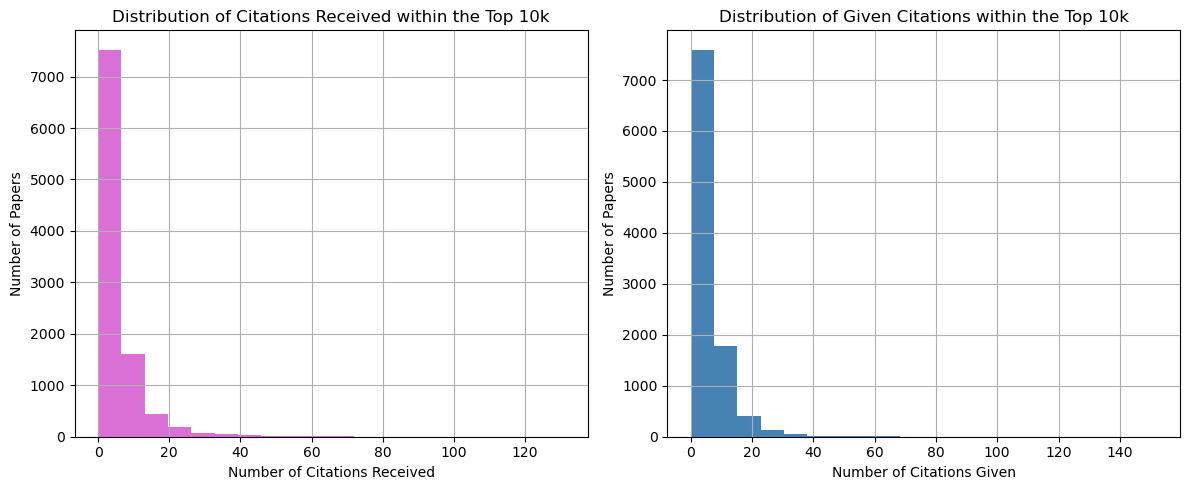

In [6]:
funct_1(citation_graph,"Citation Graph")

+-----------------+-----------------------+
|   Graph type:   |  Collaboration Graph  |
+-----------------+-----------------------+
| Number of Nodes |         21180         |
| Number of Edges |         135500        |
|     Density     | 0.0006041404082945847 |
|  Average Degree |   12.79508970727101   |
| Sparse or Dense |         Sparse        |
+-----------------+-----------------------+
+--------------+--------+
| Hubs (Top 5) | Degree |
+--------------+--------+
|  1973035492  |  346   |
|  332422508   |  325   |
|  2146468246  |  303   |
|  173839695   |  295   |
|  1976452423  |  283   |
+--------------+--------+


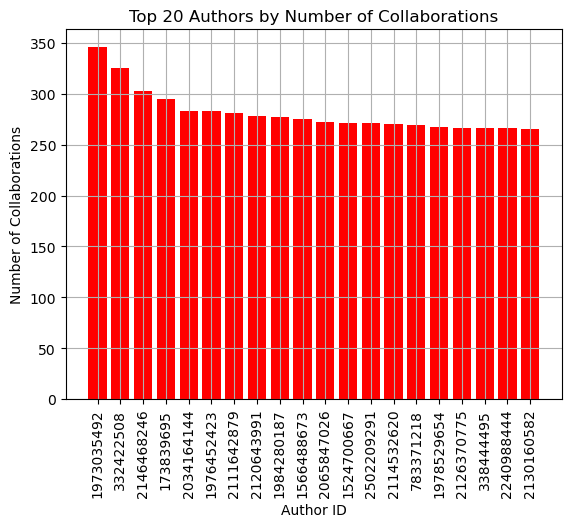

In [7]:
funct_1(collaboration_graph,"Collaboration Graph")

#### Functionality 2 - Nodes' contribution
Using this functionality, you will identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading. You will examine this using various centrality measurements.

Input:

- The graph
- A node of the graph (paper/author)
- The name of the graph

Output:

- The centrality of the node, calculated based on the following centrality measurements:
- Betweeness
- PageRank
- ClosenessCentrality
- DegreeCentrality

In [8]:
def funct_2(graph, select_node_id, graph_name):
    table = PrettyTable()                                                       # we again use PrettyTable to present our results
    table.field_names = ["Centrality Measure", "Value"]
    if select_node_id not in graph:
        print(f"Node {select_node_id} not found in the graph.")
        return

    # Check if the node is isolated
    if graph.degree(select_node_id) == 0:
        print(f"Node {select_node_id} is isolated (no connections).")
    if graph_name == "Citation Graph":
        selected_node_subgraph = graph.subgraph(graph[select_node_id])
        
        in_degree_centrality = nx.in_degree_centrality(selected_node_subgraph)
        table.add_row(["In-Degree Centrality", in_degree_centrality])

        betweenness_centrality = nx.betweenness_centrality(selected_node_subgraph)
        table.add_row(["Betweenness Centrality", betweenness_centrality])

        closeness_centrality = nx.closeness_centrality(selected_node_subgraph)
        table.add_row(["Closeness Centrality", closeness_centrality])

        pagerank = nx.pagerank(selected_node_subgraph)
        table.add_row(["PageRank", pagerank])

    elif graph_name == "Collaboration Graph":
        selected_node_subgraph = graph.subgraph(graph[select_node_id])

        degree_centrality = nx.degree_centrality(selected_node_subgraph)
        table.add_row(["Degree Centrality", degree_centrality])

        betweenness_centrality = nx.betweenness_centrality(selected_node_subgraph)
        table.add_row(["Betweenness Centrality", betweenness_centrality])

        closeness_centrality = nx.closeness_centrality(selected_node_subgraph)
        table.add_row(["Closeness Centrality", closeness_centrality])

        pagerank = nx.pagerank(selected_node_subgraph)
        table.add_row(["PageRank", pagerank])

    print(table)
    return

In [9]:
funct_2(citation_graph,2020246210,"Citation Graph") #selection of the id and graph should be left to the user

+------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   Centrality Measure   |                                                                                                                                                                                                    Value                                                                                                                                                                                                     |
+------------------------+--------------------------------------------------------------------------------------------------------------------------

In [10]:
funct_2(collaboration_graph,1973035492,"Collaboration Graph") #selection of the id and graph should be left to the user

+------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Functionality 3

*Input* :
- The graph data
- A sequence of authors_a = [ a_1, a_2, ..., a_{n-1}, a_{n} ]
- N: denoting the top N authors whose data should be considered

_Output_:
The shortest walk of collaborations you need to read to get from author a_1 to author a_n and the papers you need to cross to realize this walk.

Our approach to this problem will be implementing a breadth first search algorithm between each subsequent pair of authors in our list. This is the optimal technique in our opinion because, while this is a weighted graph, the weights don't signify distances, and we are looking for the fastest path.

Our algorithm essentially works with a queue where each element is a tuple of a node and the path to that node. First, we pop our stating point, and look for all of its neighbors. we keep track of neighbors we have seen by adding them to a set. If we haven't seen them before, we append them to the queue with the path it took to get there. We then repeat this process for every node until we reach our end node.

In [11]:
def bfs(start, end, graph):
    if start == end:
        return [start]

    visited = set()                                          # To keep track of seen nodes
    queue = deque([(start, [start])])                        # Initialize our queue for the search

    while queue:
        current_node, path = queue.popleft()

        if current_node == end:                              # End our search if we reach the end point
            return path  

        for neighbor in graph.neighbors(current_node):       # Search for neighbors for each node
            if neighbor not in visited:
                visited.add(neighbor)  
                queue.append((neighbor, path + [neighbor]))  # Add to queue unseen nodes with their path

    print(f"No path exists connecting {start} and {end}" )
    return False

def funct_3(author_id_sequence = list, N = int, graph = collaboration_graph):

    # First, a few assertions to ensure everything is working as needed
    assert N <= 21179, ("Please remember that there are 21179 nodes in total. N must be less than or equal.")
    assert len(author_id_sequence) >= 2, ("Please choose more than 2 authors.")
    
    # Second, we get the top N nodes by number of collaborations (sum of Weights of edges coming out of each node). 
    # We also include additional nodes just outside the top N but with the same weight since weights are discreet and
    # to stay fair. 
    top_N_authors = {node: sum(data["weight"] for _,_,data in graph.edges(node, data = True)) for node in graph.nodes() }
    top_N_authors = sorted(top_N_authors.items(), key = lambda x: x[1], reverse=True)
    top_N_authors = [x for x in top_N_authors if x[1]>=top_N_authors[N][1]]
    top_N_author_ids = [author_id for author_id, _ in top_N_authors]
    for author_id in author_id_sequence:
        if author_id not in top_N_author_ids:
            raise AssertionError(f"Author ID [{author_id}] not in top {N} authors by collaborations.")
    smaller_graph = graph.subgraph(top_N_author_ids)   

    # Now that we have ensured that we can start, Our approach will be a breadth first search considering tHat our weights
    # don't signify distances, this way we can ensure finding the shortest path (lowest degree of separation) between any 
    # two authors.
    shortest_path =[author_id_sequence[0]]
    for i in range(len(author_id_sequence)-1):
        initial = author_id_sequence[i]
        final = author_id_sequence[i+1]
        current_path = bfs(initial, final, smaller_graph)
        if type(current_path) == str:
            solved = False
            print(current_path)
            if len(shortest_path) > 2 and len(author_id_sequence) >2:
                print(f"Our current shortest path is {shortest_path} of length {len(shortest_path)}.")
        else:
            solved = True
            shortest_path.extend(current_path[1:])

    # Now lets list a path of papers to follow to go start to end.
    if solved:
        nodetable = PrettyTable()
        nodetable.add_column("Node ID",shortest_path)
       # print(f"Our shortest path is {shortest_path} of length {len(shortest_path)}.", )

        cut_subgraph = nx.subgraph(collaboration_graph,shortest_path) #create a subgraph using the nodes of the shortest path, since the original graph is extremely crowded
        
        labels = nx.get_edge_attributes(cut_subgraph,'weight') #weights, so that in the plot every edge has a different width

        path_edges = list(zip(shortest_path,shortest_path[1:])) #by zipping the shortest path we get a list of edges between the two nodes
        path_order = {t: i+1 for i, t in enumerate(path_edges)} #we create a dictionary with the following structure:
        #{(node1,node2): 1, (node2,node2):2...} with a sequential integer as value, which is the order of the walk

        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(cut_subgraph,k=0.5)
        nx.draw_networkx_nodes(cut_subgraph,pos,nodelist=shortest_path,node_color='lightblue')
        nx.draw_networkx_edges(cut_subgraph,pos,edgelist=labels.keys(),edge_color='b',width=list(labels.values())) #the width of the edge is linked to the weight
        nx.draw_networkx_edge_labels(cut_subgraph,pos,edge_labels=path_order,font_size=10,font_color='r') #we then use the path_order defined above as edge_label
        nx.draw(cut_subgraph, pos, with_labels=True,width=0.3,node_size=500,font_size=9)
        nx.draw_networkx_nodes(collaboration_graph, pos, nodelist=[shortest_path[0],shortest_path[-1]], node_color="green",node_size=500) #color code the first and last node of
        #the walk
        plt.axis('equal')
        plt.show()


        idtable = PrettyTable()

        papers = []
        for i in range(len(shortest_path)-1):
            papers.append(collaboration_graph.get_edge_data(shortest_path[i], shortest_path[i+1])["paper_ids"][0])

        titles = []
        for paper in papers:
            titles.append(first_10k_rows[first_10k_rows["id"] == paper]["title"].values[0])   


        print("The path to take between these authors is the following papers:")    
        print("")
        idtable.add_column("Paper ID",papers)
        idtable.add_column("Titles",titles)

        print(idtable) 
        

      

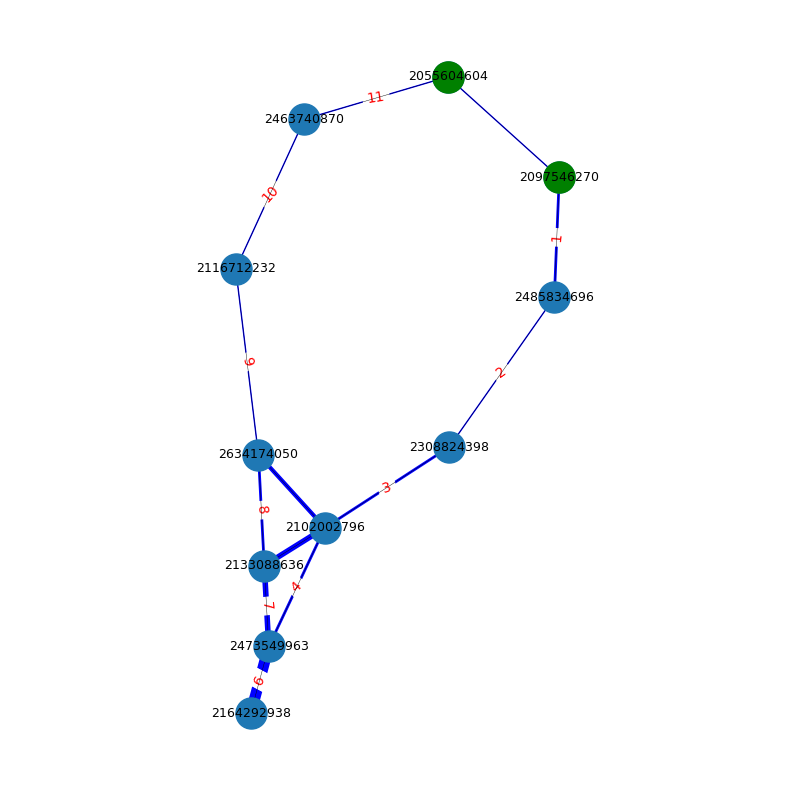

The path to take between these authors is the following papers:

+------------+----------------------------------------------------------------------------------+
|  Paper ID  |                                      Titles                                      |
+------------+----------------------------------------------------------------------------------+
| 2950178297 |   Show, Attend and Tell: Neural Image Caption Generation with Visual Attention   |
| 2384495648 |   Theano: A Python framework for fast computation of mathematical expressions    |
| 2097117768 |                          Going deeper with convolutions                          |
| 2155893237 |           Caffe: Convolutional Architecture for Fast Feature Embedding           |
| 2613718673 |  Faster R-CNN: towards real-time object detection with region proposal networks  |
| 2613718673 |  Faster R-CNN: towards real-time object detection with region proposal networks  |
| 2102605133 | Rich Feature Hierarchies for Accurate 

In [12]:
length= funct_3([2097546270,2164292938,2055604604], 20000)

##### ChatGPT implementation

Given prompt:
Given a NetworkX graph of authors as nodes, connected by edges if they have collaborated together. The graph is weighted and undirected.

Taking collaboration_graph as graph name, given a sequence of authors, find the fastest path that crosses all authors in order, and implement this with python. Write the algorithm yourself, don't use built-in algorithms.

Analysis:
ChatGPT gave me dijkstra's algorithm as a solution to this problem. This is a known algorithm for finding shortest path search in weighted graphs. It works as we can see below, but the solution it gave was 9 steps away and ours was 8. The algorithm it provided might have a lower overall weight, but considering that our weights only represent the number of works in common and not distance, this is not ideal.

([331124168, 2889793201, 2969484184, 2018227268, 2167218018, 2137015694, 2080847109, 2160671624, 2470140333], 9)


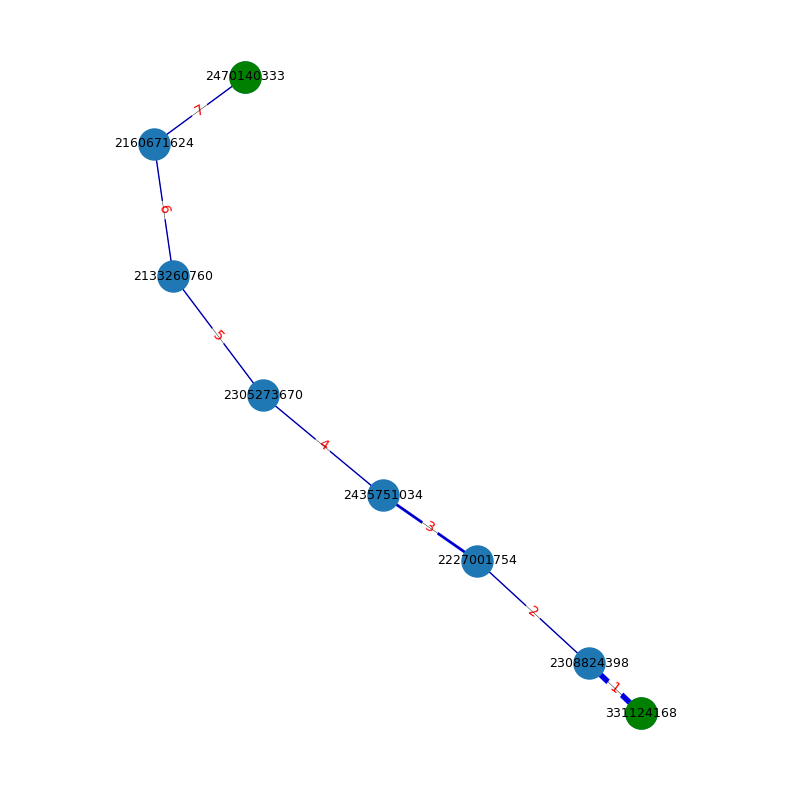

The path to take between these authors is the following papers:

+------------+----------------------------------------------------------------------------------------+
|  Paper ID  |                                         Titles                                         |
+------------+----------------------------------------------------------------------------------------+
| 2097117768 |                             Going deeper with convolutions                             |
| 2384495648 |      Theano: A Python framework for fast computation of mathematical expressions       |
| 2949608212 |                            Trust Region Policy Optimization                            |
| 2164522996 |                    Kalman filtering with intermittent observations                     |
| 2145873277 | Stochastic geometry and random graphs for the analysis and design of wireless networks |
| 2109159967 |                         Femtocells: Past, Present, and Future                          |

In [13]:
import heapq

def dijkstra(graph, start, end):
    """
    Dijkstra's algorithm for finding the shortest path in a weighted graph.
    """
    distances = {node: float('infinity') for node in graph}
    distances[start] = 0
    priority_queue = [(0, start)]
    path = {start: None}

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        if current_node == end:
            break

        for neighbor in graph.neighbors(current_node):
            # Use the weight of the edge if specified, otherwise default to 1
            weight = graph[current_node][neighbor].get('weight', 1)
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                path[neighbor] = current_node
                heapq.heappush(priority_queue, (distance, neighbor))

    # Reconstruct the shortest path
    shortest_path = []
    while end is not None:
        shortest_path.append(end)
        end = path[end]
    return shortest_path[::-1]
def find_fastest_path(collaboration_graph, author_sequence):
    """
    Find the fastest path that crosses all authors in the given sequence.
    """
    total_path = []

    for i in range(len(author_sequence) - 1):
        start_author = author_sequence[i]
        end_author = author_sequence[i + 1]

        # Get shortest path for each pair of authors
        path = dijkstra(collaboration_graph, start_author, end_author)

        # Avoid duplication of nodes in the concatenated path
        if total_path and path:
            total_path.extend(path[1:])
        else:
            total_path.extend(path)

    return total_path, len(total_path)

print(find_fastest_path(collaboration_graph,[331124168,2470140333]))
funct_3([331124168,2470140333], 21179)


#### Functionality 4 - Disconnecting Graphs
Input:

- The graph data
- authorA: a paper to which will relate sub-graph G_a
- authorB: a paper to which will relate sub-graph G_b
- N: denoting the top N authors that their data should be considered

Output:

- The minimum number of edges (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

This problem is a min-cut problem, which is defined as "A Minimum Cut is a a way to partition a (weighted) graph into two disjoint graphs (a cut) so that the edges connecting these two graphs are of minimal weight in summation."

One approach to solving this problem is taking our weighted undirected graph, as a weighted flow graph with each edge having two directions of admissable flow. Author A will be our starting _Source_ node and author B will be our ending _Sink_ node. The weight of each edge represents it's _Flow Capacity_. The Max-Flow Min-Cut theorem states that the Maximum capacity of Flow we can achieve in our graph, is equal to the Minimum weight of cuts needed to disconnect the two nodes. 

Our approach was the following:

- First, create a function **create_residual_graph()** that takes in as input our original graph, initializes a residual graph, an identical copy, but has flow and capacity (equal to edge weight) as it's edge attributes. We wil use this graph to constantly update our flow and capacity.

- Second, we create a function **Edmonds_bfs()** which, given two authors and a graph, implements a breadth first search similar to what we implemented above, but it checks for whether it has seen the neighboring node before and if the edge it is attempting to cross has capacity > 0:

- Next, we implement the **Edmonds-Karp Algorithm** with the function **Edmonds_karp()**, this function iteratively implements **Edmonds_bfs()**, retrieves the path the function returned, finds the edge with the lowest capacity **C** as the path's **Max_flow**, and then using **Update_residual_path()**, updates the flow of those path edges on the residual network by **+C** and the capacity by **-C**. 

- By doing this iteratively, edges will start having their capacity drop to 0. Our **Edmonds_bfs()** will find the next shortest path, which will get updated, until no valid paths are available anymore. At each iteration, we add the **Max_flow** of the paths we get to get the max_flow of our network.

- Now using the Max-Flow Min-Cut theorem, we implement a new breadth first search on our finalized residual graph using **Bfs_for_cutting()** that tells us which nodes are reachable from the source, and which nodes are unreachable. Knowing that we have maxed out the capacities that we can and the graph is at maximum flow, all pairs of nodes (U,V) that has an edge between them and only one can be reached from the source are edges we should cut to split the graph into two subgraphs.

This was a quiet difficult algorithm to implement, YouTube helped a lot in understanding it how its supposed to work.

In [14]:

def create_residual_graph(graph):
    residual_graph = nx.Graph()
    for u, v, data in graph.edges(data=True):
    
        residual_graph.add_edge(u, v, capacity=data['capacity'], flow=0)
    return residual_graph

def update_residual_graph(residual_graph, path, flow):
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        residual_graph[u][v]['flow'] += flow
        residual_graph[u][v]['capacity'] -= flow

def edomonds_bfs(source, sink, graph):
    if source == sink:
        return [source]

    visited = set()                                          # To keep track of seen nodes
    queue = deque([(source, [source])])                        # Initialize our queue for the search

    while queue:
        current_node, path = queue.popleft()

        if current_node == sink:                              # End our search if we reach the end point
            return path  

        for neighbor in graph.neighbors(current_node):       # Search for neighbors for each node
            if neighbor not in visited and graph[current_node][neighbor]['capacity'] > 0:
                visited.add(neighbor)  
                queue.append((neighbor, path + [neighbor]))  # Add to queue unseen nodes with their path

    return False

def bfs_for_cutting(source, graph): 
    visited = set()
    queue = deque([source])

    while queue:
        current_node = queue.popleft()
        visited.add(current_node)

        for neighbor in graph.neighbors(current_node):
            if neighbor not in visited and graph[current_node][neighbor]['capacity'] > 0:
                queue.append(neighbor)

    return visited

def edmonds_karp(graph, source, sink):
    rGraph = create_residual_graph(graph)
    max_flow = 0

    while True:
        path = edomonds_bfs(source, sink, rGraph)
        if not path:
            break

        path_flow = float('inf')
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            path_flow = min(path_flow, rGraph[u][v]['capacity'])

        update_residual_graph(rGraph, path, path_flow)
        max_flow += path_flow
    return max_flow, rGraph

def min_cut(graph, source, sink, N):
    assert N <= 21179, ("Please remember that there are 21179 nodes in total. N must be less than or equal.")

    top_N_authors = {node: sum(data["weight"] for _,_,data in graph.edges(node, data = True)) for node in graph.nodes() }
    top_N_authors = sorted(top_N_authors.items(), key = lambda x: x[1], reverse=True)
    top_N_authors = [x for x in top_N_authors if x[1]>=top_N_authors[N][1]]
    top_N_author_ids = [author_id for author_id, _ in top_N_authors]
    if (source or sink) not in top_N_author_ids:
        raise AssertionError(f"Source or sink not in top {N} authors by collaborations.")
    
    smaller_graph = graph.subgraph(top_N_author_ids)  
    max_flow, rGraph = edmonds_karp(smaller_graph, source, sink)
    visited = bfs_for_cutting(source, rGraph)
    cut_set = []

    for u, v in smaller_graph.edges():
        if u in visited and v not in visited:
            cut_set.append((u, v))

    print(f"Our minimum cut weight is {max_flow}. The minimum cut weight calculated using nx.minimum_cut_value is {nx.minimum_cut_value(smaller_graph,source, sink)}.")
    print(f"The edges to cut are {cut_set}")
    print(f"The number of edges to cut is {len(cut_set)}")




    selected_node_subgraph = collaboration_graph.subgraph([source,sink]) #subgraph from the two inputs

    plt.figure(figsize=(20, 20))
    plt.title('Original Graph',fontsize = 30)
    pos = nx.spring_layout(graph,k=1)
    nx.draw(graph, pos, with_labels=False,width=0.1, 
            node_color='lightblue', node_size=10)


    plt.figure(figsize=(20, 20))

    plt.title('Graph with highlighted nodes (green) and cut edges (red)',fontsize = 30)
   
    pos = nx.spring_layout(graph,k=1)
    nx.draw(graph, pos, with_labels=False,width=0.1, 
            node_color='lightblue', node_size=10)
    
    nx.draw_networkx_edges(graph,pos,edgelist=cut_set,edge_color='red') #the cut edges are shown in red
    nx.draw_networkx_nodes(graph, pos, nodelist=[source,sink], node_color="green",node_size=500,label=True) #color code the two nodes
    nx.draw_networkx_edges(selected_node_subgraph,pos,edge_color="green")# the edge the connects the two nodes is green


    plt.figure(figsize=(20, 20))

    
    plt.title('Magnified and numbered version of the cut edges',fontsize = 30)

    pos = nx.spring_layout(graph,k=1)
    nx.draw(selected_node_subgraph, pos, with_labels=False,width=0.1, 
            node_color='lightblue', node_size=500)
   
    path_edges = cut_set 
    path_order = {t: i+1 for i, t in enumerate(path_edges)}

    nx.draw_networkx_edges(graph,pos,edgelist=cut_set,edge_color='red') #the width of the edge is linked to the weight
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=path_order,font_size=15,font_color='r') #numbering the cut edges so it's easier to see
    nx.draw_networkx_nodes(graph, pos, nodelist=[source,sink], node_color="green",node_size=500) #color code the two nodes in input
    nx.draw_networkx_edges(selected_node_subgraph,pos,edge_color='green') #now the edge that connects the two nodes is green


    plt.figure(figsize=(20, 20))

    
    plt.title('Final Graph (after removing links)',fontsize = 30)

    graph.remove_edges_from(cut_set)

    pos = nx.spring_layout(graph,k=1)
    
    nx.draw(graph, pos, with_labels=False,width=0.1, 
            node_color='lightblue', node_size=10)

    nx.draw_networkx_nodes(graph, pos, nodelist=[source,sink], node_color="green",node_size=500) #color code the two nodes in input
    nx.draw_networkx_edges(selected_node_subgraph,pos,edge_color='green') #now the edge that connects the two nodes is green
    print(graph.degree(source),graph.degree(sink))


    return cut_set, max_flow, rGraph


Our minimum cut weight is 94. The minimum cut weight calculated using nx.minimum_cut_value is 94.
The edges to cut are [(2042923958, 1772069374), (2042923958, 309212092), (2042923958, 2163125745), (2042923958, 2223018965), (2042923958, 2899910134), (2042923958, 2568227796), (2042923958, 2192186815), (2042923958, 2032363958), (2042923958, 2569834469), (2042923958, 1999902674)]
The number of edges to cut is 10
84 94


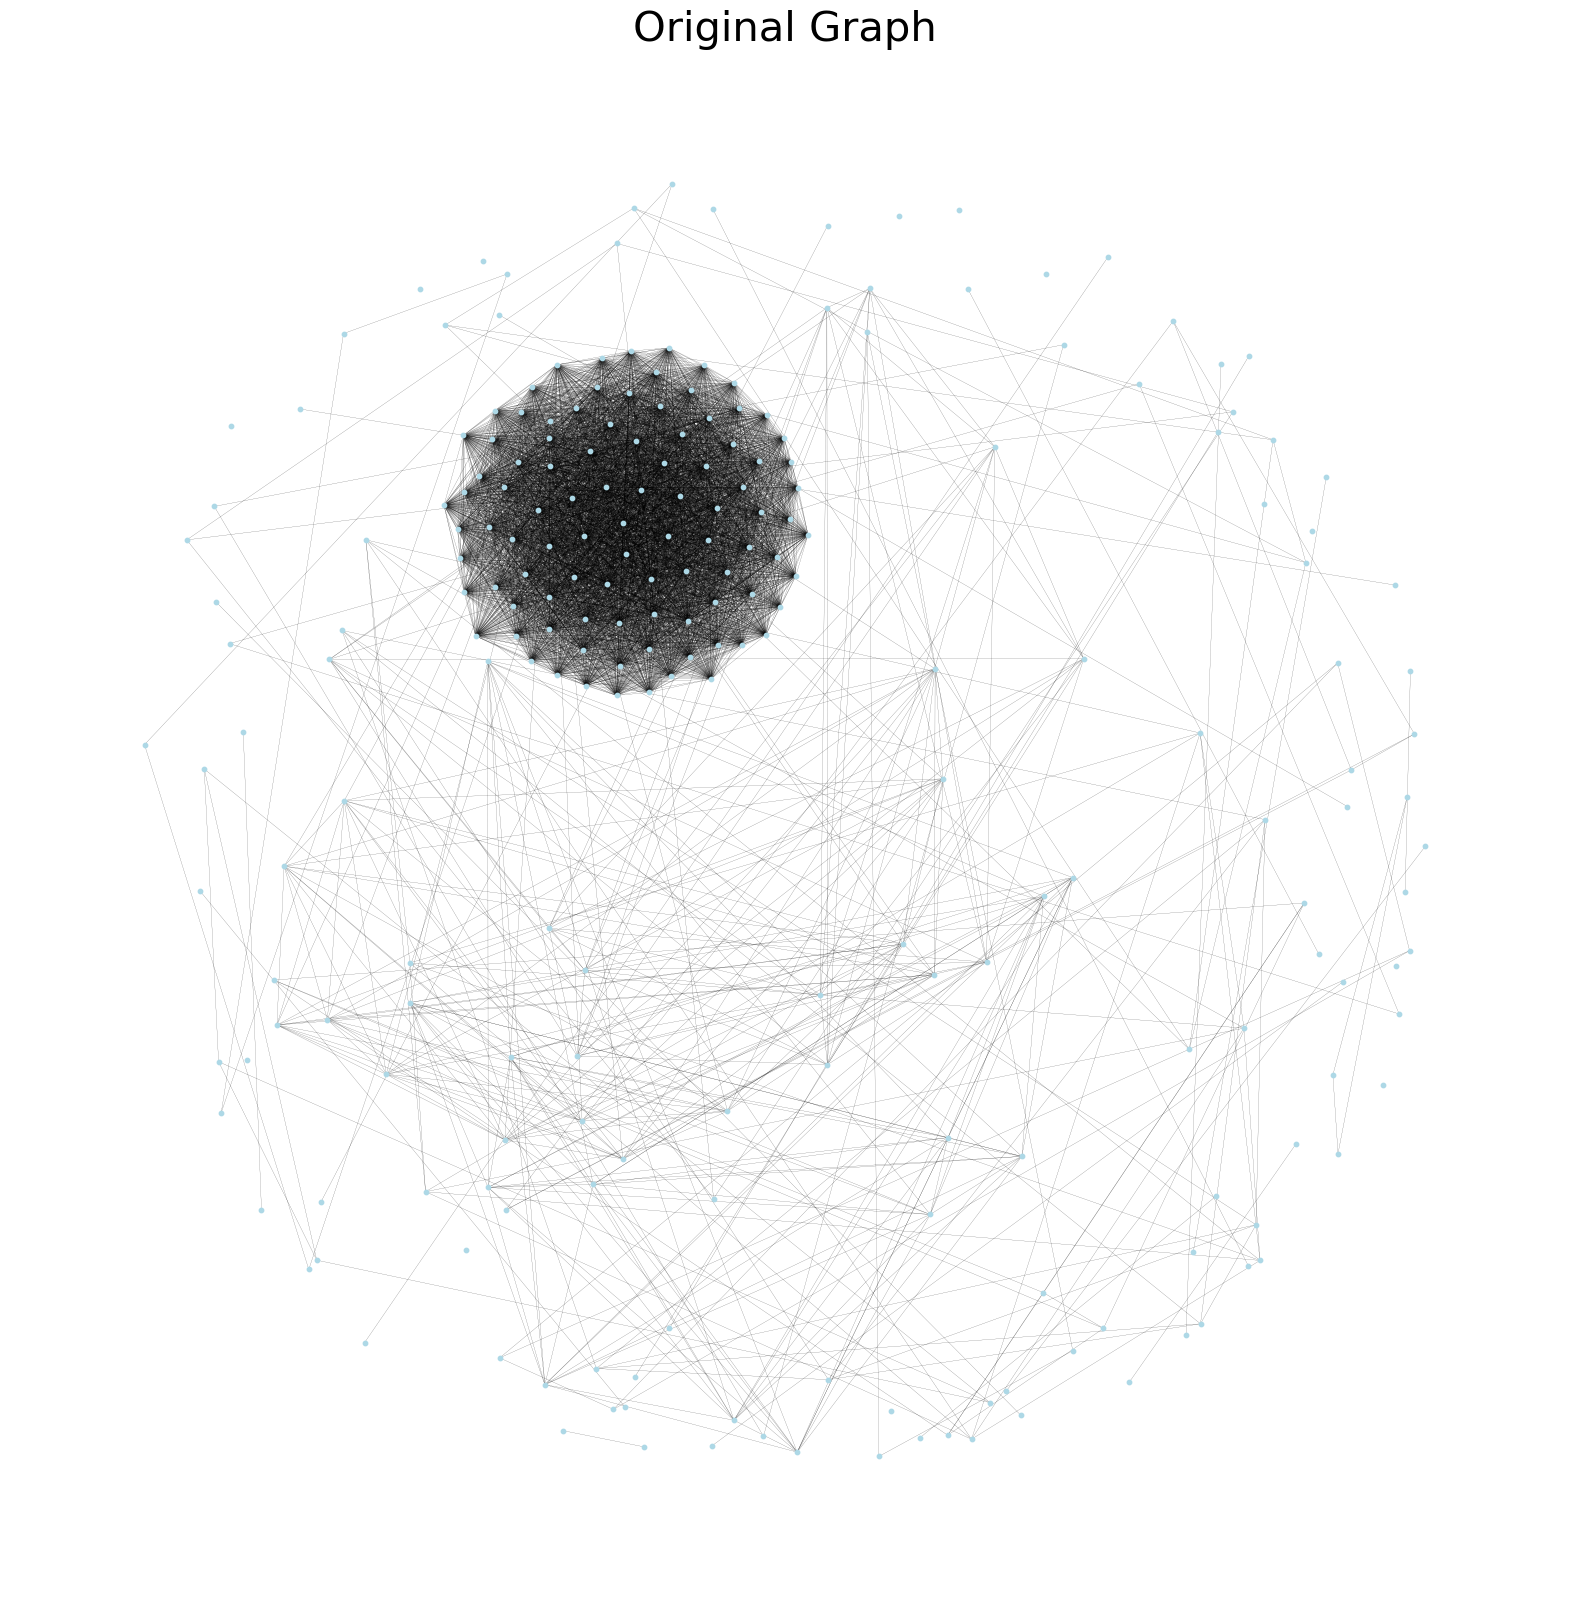

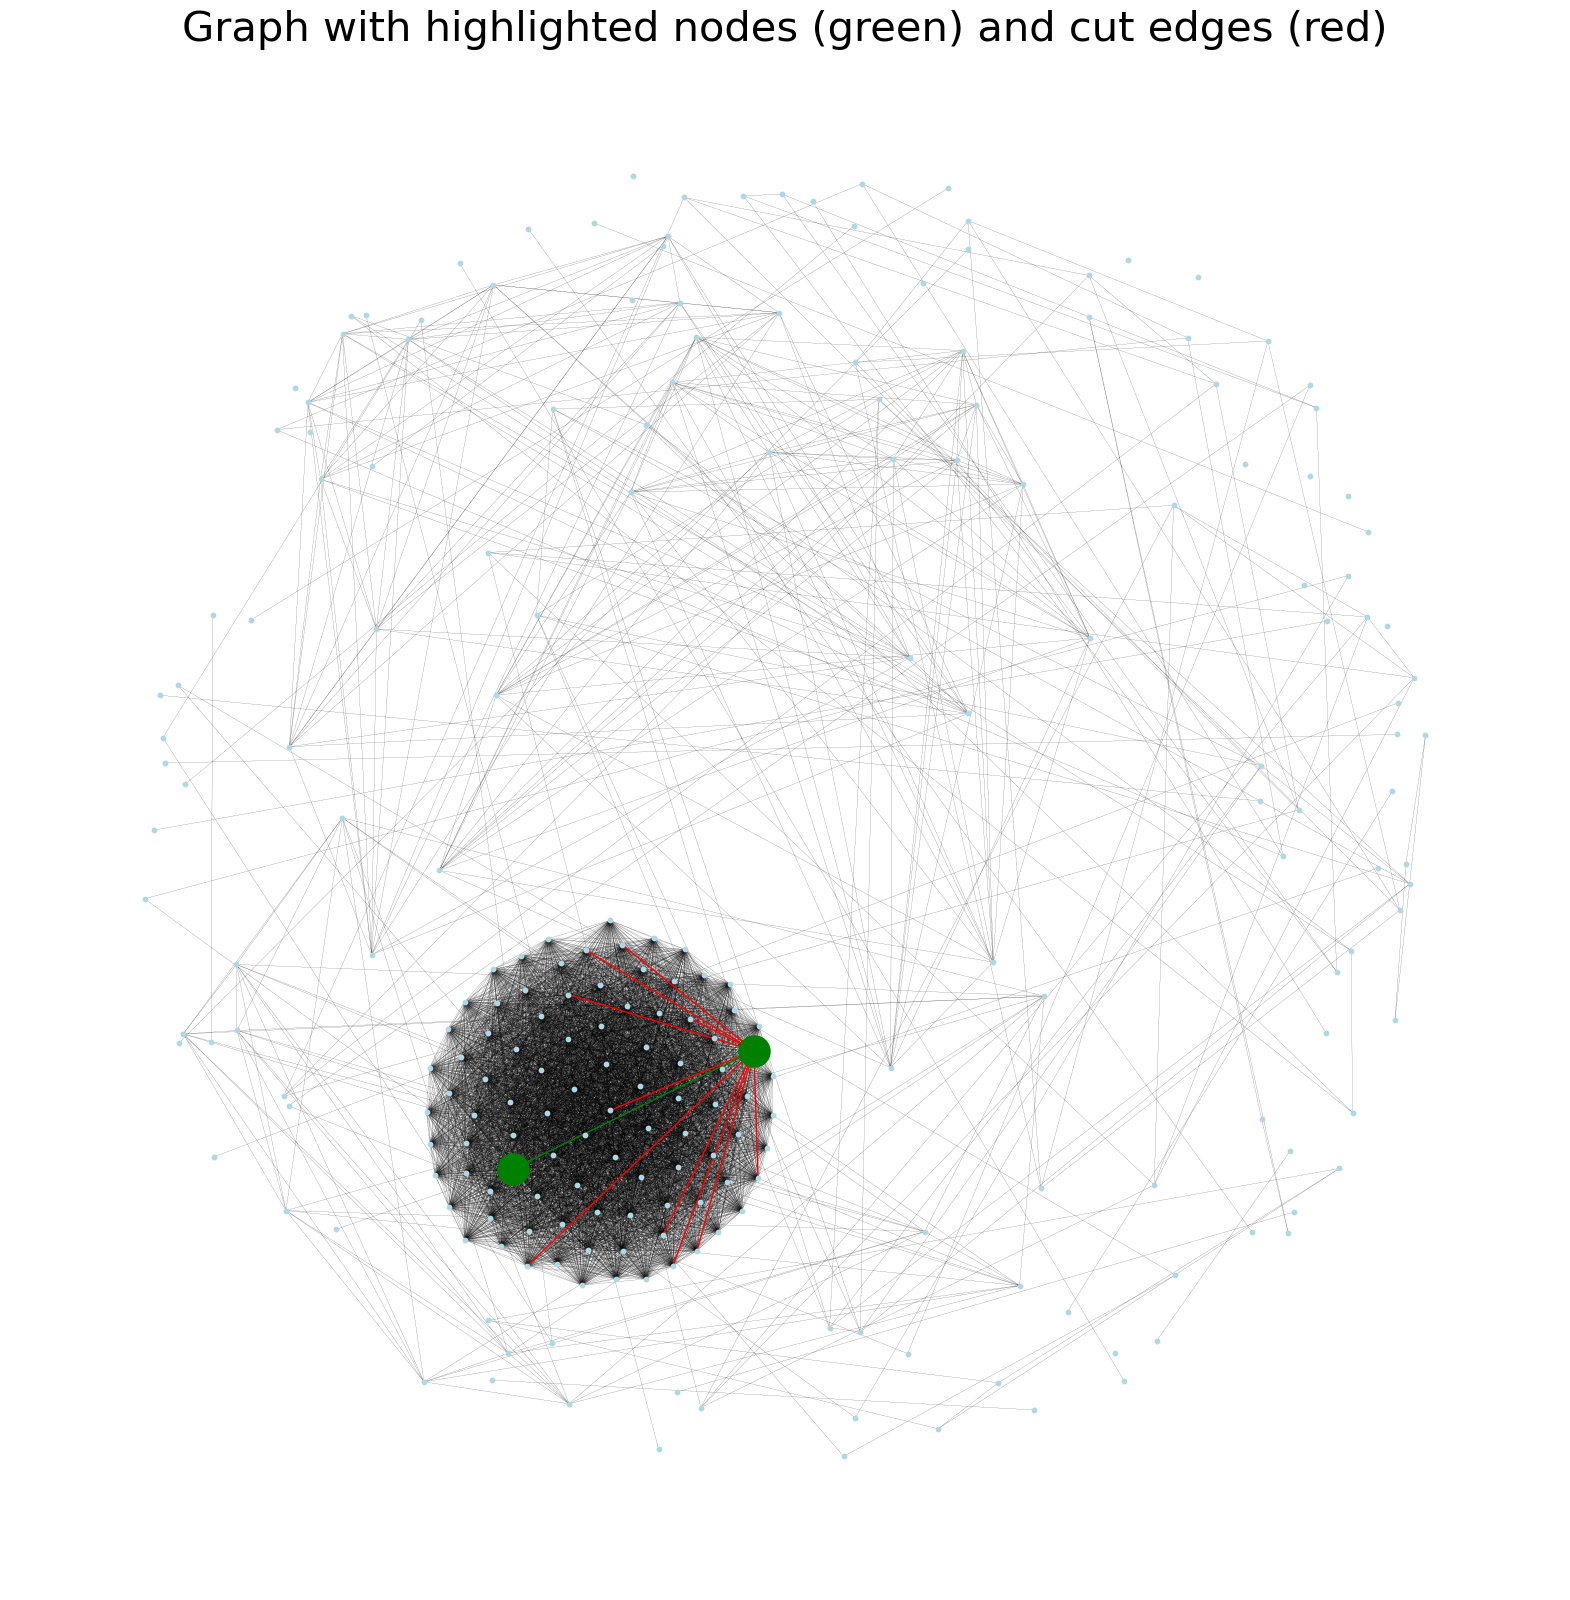

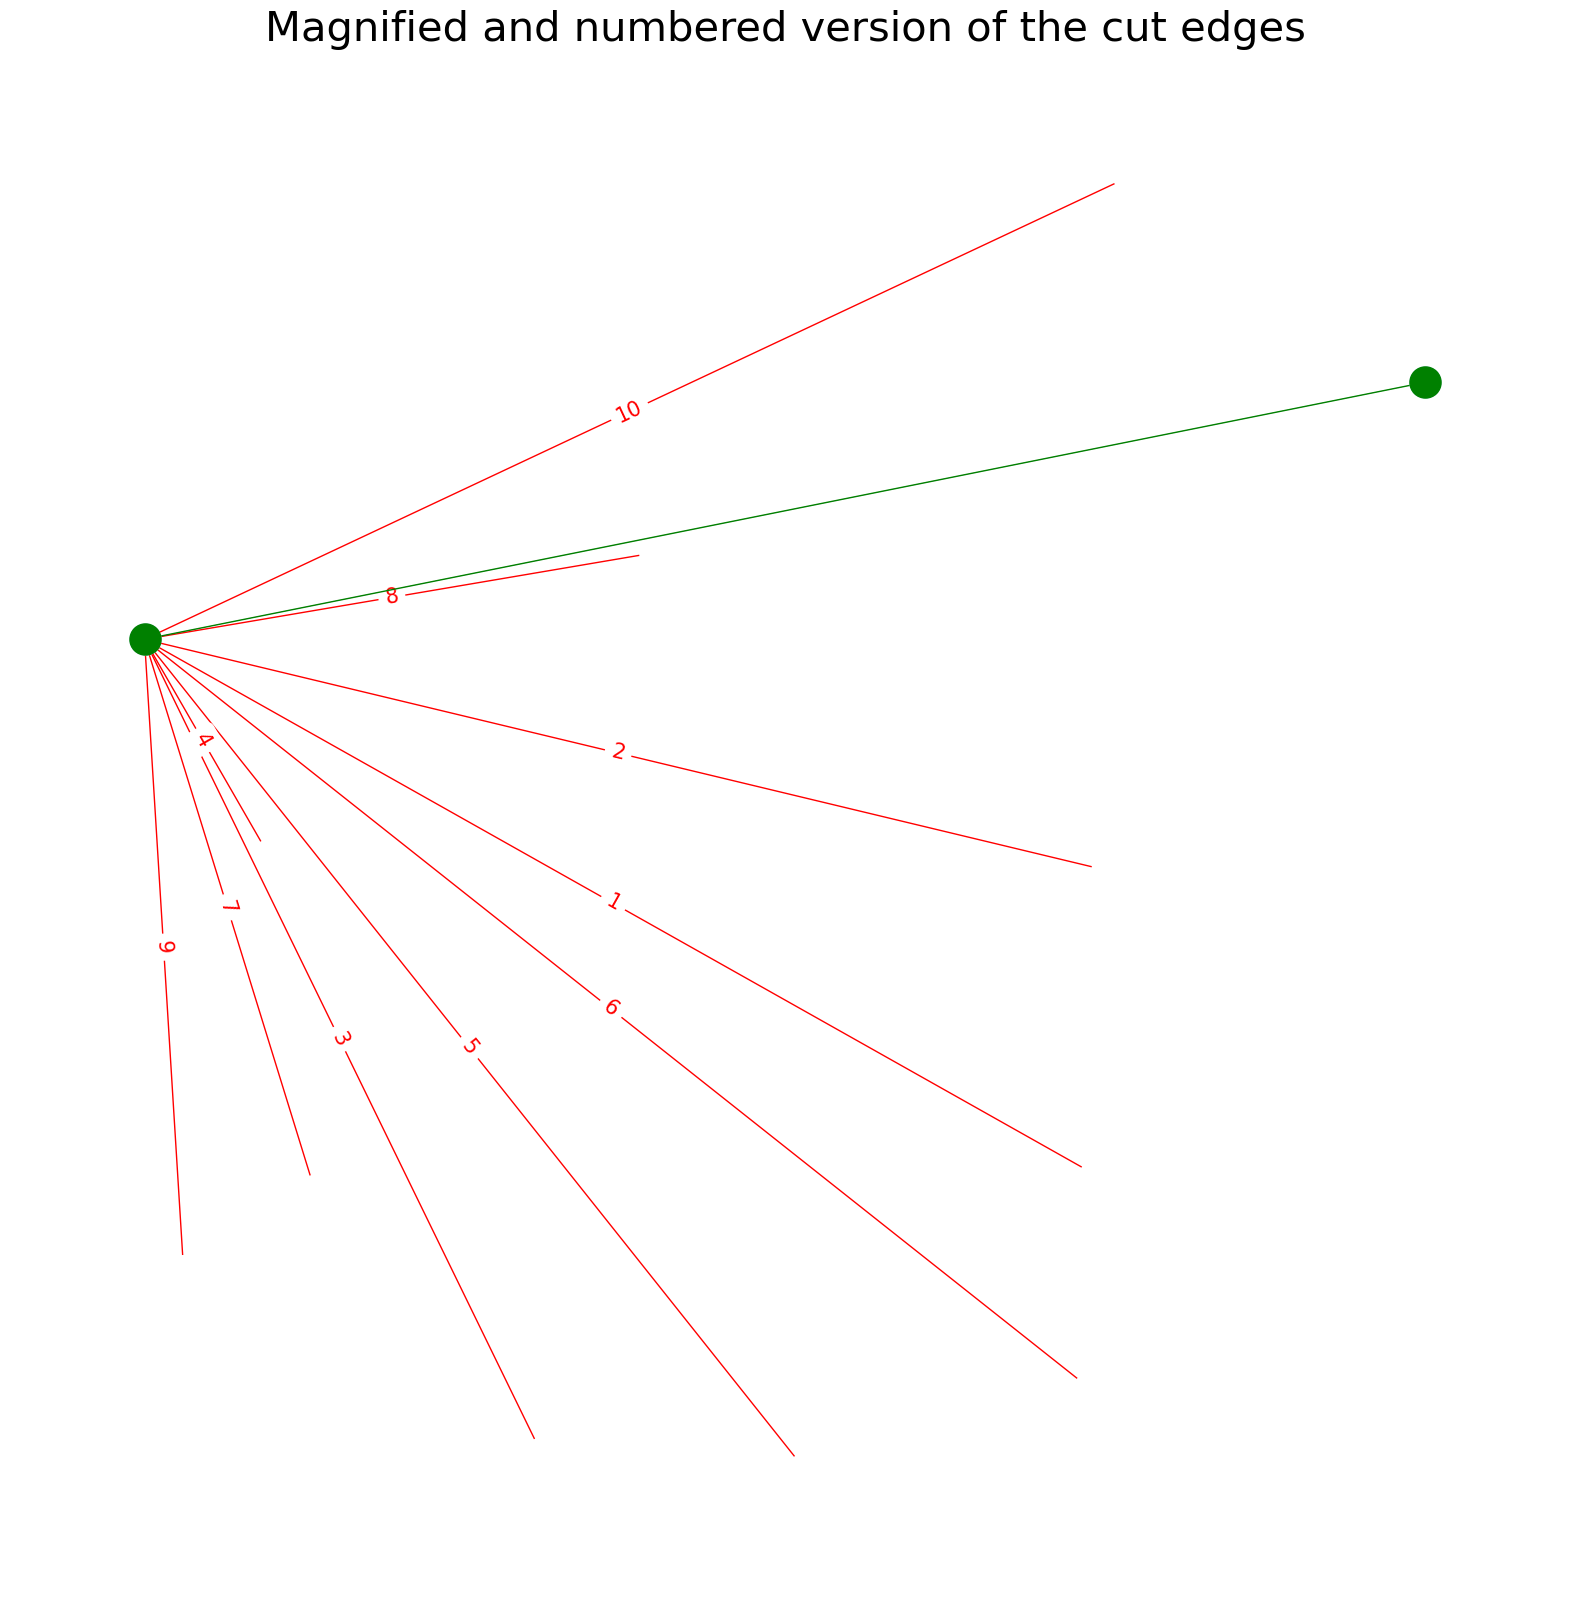

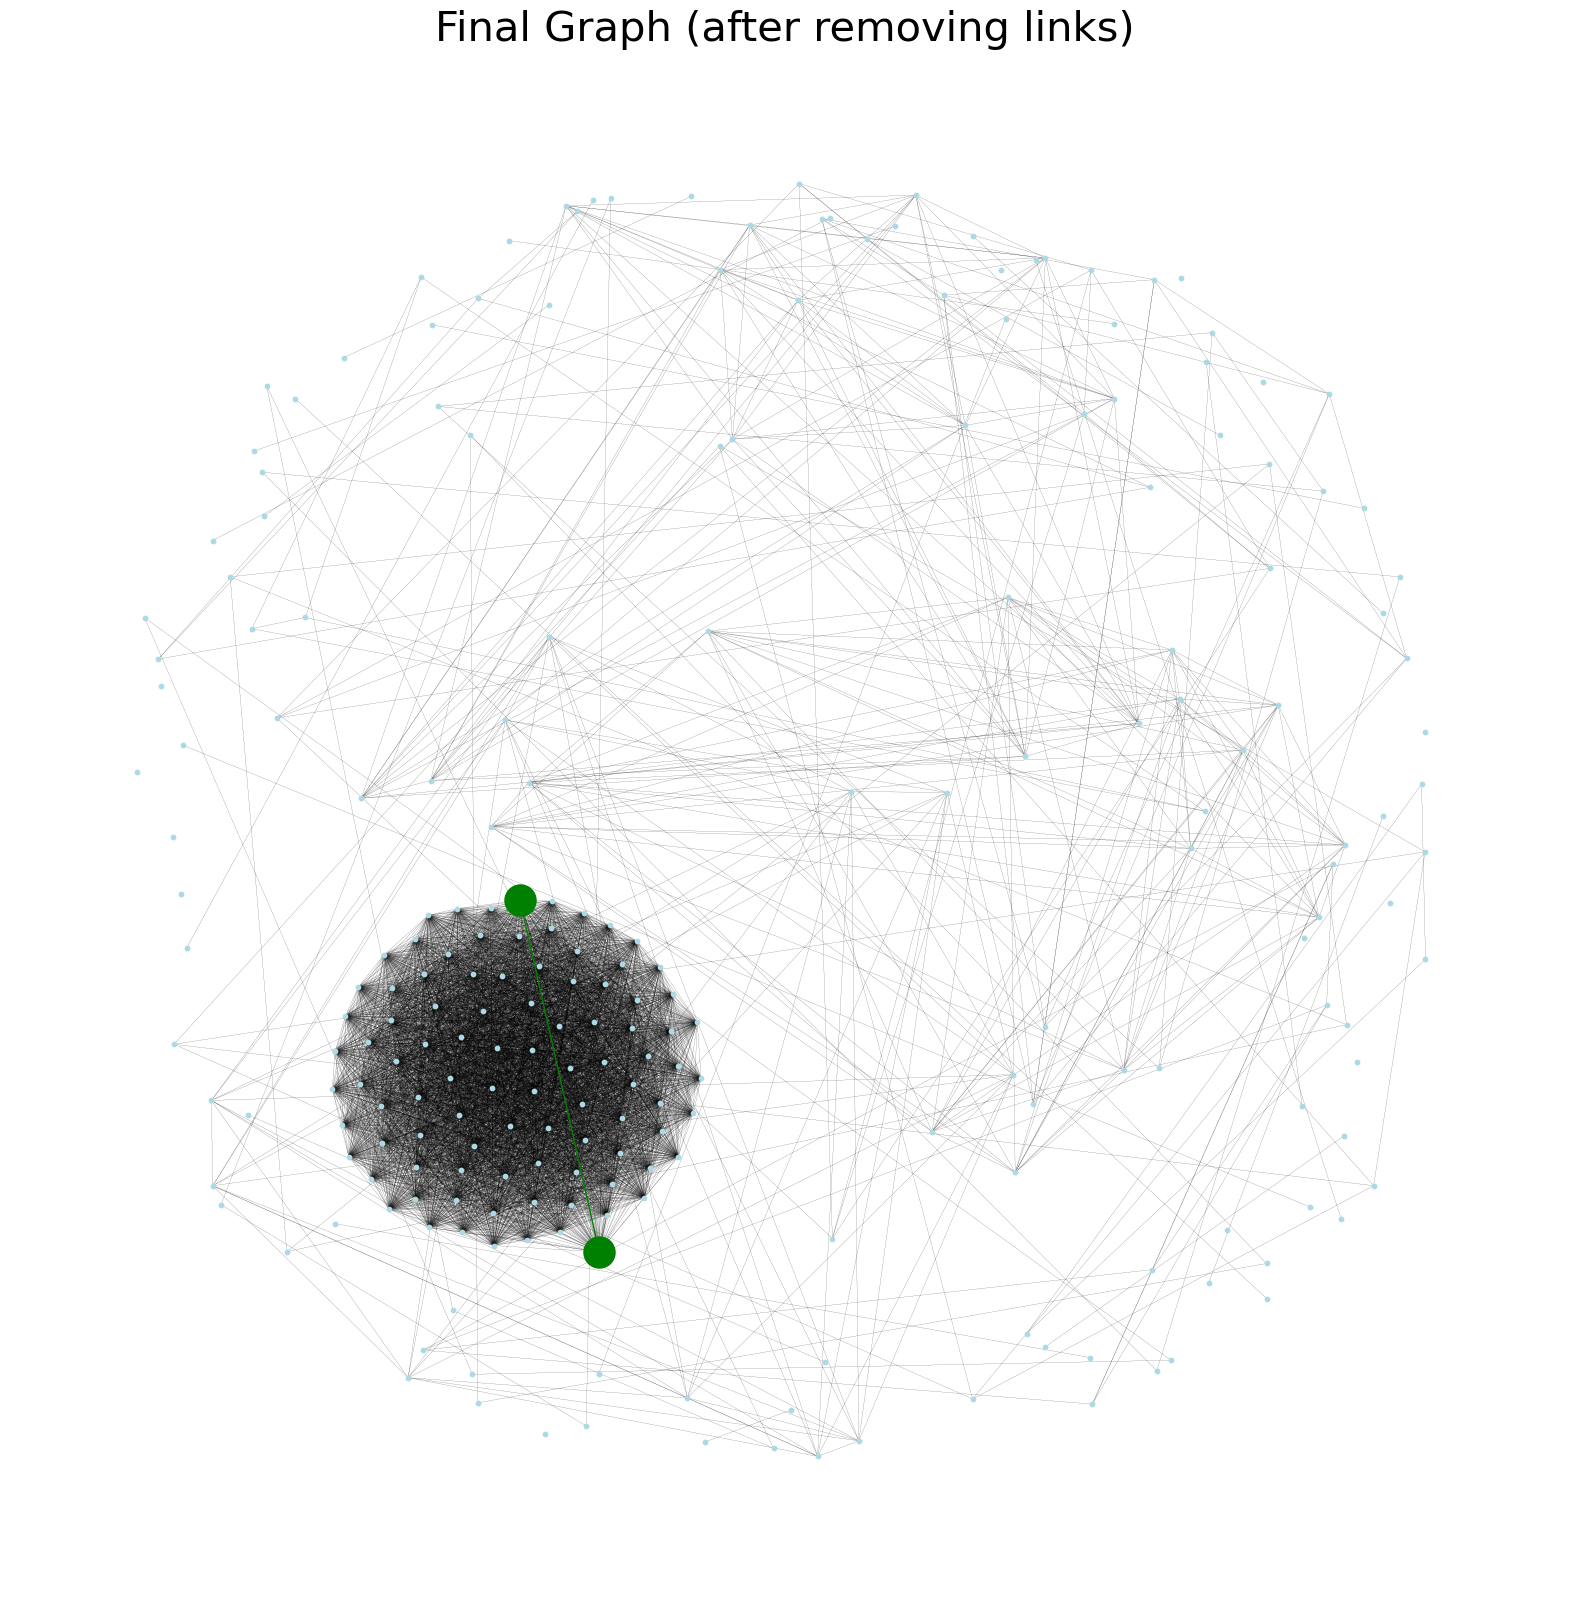

In [15]:

small = create_collaboration_graph(first_10k_rows[850:900])

cuts, max_flo, residual = min_cut(small,2042923958, 2155122220, 100)
